# Data cleaning and pre processing

In [296]:
import os
os.chdir("/Users/jam/msc/course-works")
print(os.getcwd())  # Verify the change

/Users/jam/msc/course-works


In [ ]:
#!pip install mlxtend

In [475]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [300]:
df = pd.read_csv("online_retail.csv")

In [302]:
# check data header
df.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [304]:
# check data types and information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   index        541909 non-null  int64  
 1   InvoiceNo    541909 non-null  object 
 2   StockCode    541909 non-null  object 
 3   Description  540455 non-null  object 
 4   Quantity     541909 non-null  int64  
 5   InvoiceDate  541909 non-null  object 
 6   UnitPrice    541909 non-null  float64
 7   CustomerID   406829 non-null  float64
 8   Country      541909 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 37.2+ MB


In [306]:
# check data shape
print(f"Number of rows and columns: {df.shape}")

Number of rows and columns: (541909, 9)


In [308]:
# check data types
df.dtypes

index            int64
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

### Handle data types

In [311]:
# Convert CustomerID from float to int (handling NaN values first)
df["CustomerID"] = df["CustomerID"].fillna(0).astype(int)  # Replace NaN with 0 before conversion
# Print the updated data type
print(df["CustomerID"].dtype)

int64


In [313]:
# Convert InvoiceDate to datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Print the updated data type
print(df["InvoiceDate"].dtype)

datetime64[ns]


In [315]:
# check data types
df.dtypes

index                   int64
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
dtype: object

In [317]:
#Ensure no missing values are available in the dataset
print(df.isnull().sum())  

index             0
InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64


In [319]:
# Check for empty or null values
print(f"Number of null values for Description column: {df["Description"].isnull().sum()}")

Number of null values for Description column: 1454


In [321]:
# Check for '??' values
print(f"Rows with ?? values in the Description column: {df[df["Description"] == "??"].shape[0]}")

Rows with ?? values in the Description column: 7


In [323]:
# Check for '?' values
print(f"Rows with ?? values in the Description column: {df[df["Description"] == "?"].shape[0]}")

Rows with ?? values in the Description column: 47


In [325]:
# Find meaningful descriptions: Get the most frequently used description for each StockCode
stockcode_to_description = df[df["Description"].notnull()].groupby("StockCode")["Description"].agg(lambda x: x.mode()[0])

# Display a few mappings
print(stockcode_to_description.head(10))

df["Description"] = df["Description"].fillna(df["StockCode"].map(stockcode_to_description))
df.loc[df["Description"] == "??", "Description"] = df["StockCode"].map(stockcode_to_description)
df.loc[df["Description"] == "?", "Description"] = df["StockCode"].map(stockcode_to_description)

StockCode
10002      INFLATABLE POLITICAL GLOBE 
10080         GROOVY CACTUS INFLATABLE
10120                     DOGGY RUBBER
10123C           HEARTS WRAPPING TAPE 
10124A     SPOTS ON RED BOOKCOVER TAPE
10124G        ARMY CAMO BOOKCOVER TAPE
10125          MINI FUNKY DESIGN TAPES
10133     COLOURING PENCILS BROWN TUBE
10135     COLOURING PENCILS BROWN TUBE
11001      ASSTD DESIGN RACING CAR PEN
Name: Description, dtype: object


In [327]:
# Check for empty or null values
print(f"Number of null values for Description column after filna: {df["Description"].isnull().sum()}")

Number of null values for Description column after filna: 112


In [329]:
# Check for '??' values
print(f"Number of ?? values for Description column after filna: {df[df["Description"] == "??"].shape[0]}")

Number of ?? values for Description column after filna: 0


In [331]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of duplicate rows: 0


In [333]:
null_percentage = (df["CustomerID"].isnull().sum() / len(df)) * 100
print(f"Percentage of missing CustomerID values: {null_percentage:.2f}%")

Percentage of missing CustomerID values: 0.00%


In [335]:
# Due to higer percentage of missing customer id values, this could be due to guest checkouts, return transactions or invalid transactions

In [337]:
# Check for negative values in Quantity and UnitPrice
print(df[df["Quantity"] <= 0].shape[0], "rows with negative Quantity")
print(df[df["UnitPrice"] <= 0.0].shape[0], "rows with zero/negative UnitPrice")

10624 rows with negative Quantity
2517 rows with zero/negative UnitPrice


In [339]:
# Check rows where Quantity is negative and CustomerID is null
negative_quantity_null_customer = df[(df["Quantity"] <= 0) & (df["CustomerID"].isnull())]
print(f"Rows with negative Quantity and missing CustomerID: {negative_quantity_null_customer.shape[0]}")

unitprice_zero_negative_percentage = (df[df["Quantity"] <= 0].shape[0] / len(df)) * 100
print(f"Percentage of rows with zero/negative UnitPrice: {unitprice_zero_negative_percentage:.2f}%")

negative_quantity_null_customer.head()

Rows with negative Quantity and missing CustomerID: 0
Percentage of rows with zero/negative UnitPrice: 1.96%


,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [341]:
# Negative or Zero value for Quantity can be due to human error, returned transactions, order cancelations or any other reason. 
# Negative or Zero value for UnitPrice can be due to human error or any other reason. 
# Filter data frame excluding invalid quantities and invalid unit prices

df_cleaned = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0.0)]
print(df_cleaned[df_cleaned["Quantity"] <= 0].shape[0], "rows with negative Quantity")
print(df_cleaned[df_cleaned["UnitPrice"] <= 0].shape[0], "rows with zero/negative UnitPrice")

0 rows with negative Quantity
0 rows with zero/negative UnitPrice


In [343]:
print(df_cleaned.isnull().sum())  

index          0
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [345]:
filtered_df = df_cleaned[df_cleaned["UnitPrice"] <= 0]
filtered_df.head(10)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [347]:
null_percentage = (df_cleaned["CustomerID"].isnull().sum() / len(df_cleaned)) * 100
print(f"Percentage of missing CustomerID values: {null_percentage:.2f}%")

Percentage of missing CustomerID values: 0.00%


In [349]:
# Number of invalid customer ids
# Count rows where CustomerID is 0
invalid_customer_ids = (df["CustomerID"] == 0).sum()

# Print the result
print(f"Number of invalid (zero as value) CustomerID: {invalid_customer_ids}")

Number of invalid (zero as value) CustomerID: 135080


## Descriptive Analysis

In [352]:
df_cleaned.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [354]:
df_cleaned.describe()

,index,Quantity,InvoiceDate,UnitPrice,CustomerID
count,530104.000000,530104.000000,530104,530104.000000,530104.000000
mean,271365.705603,10.542037,2011-07-04 20:16:05.225087744,3.907625,11479.646222
min,0.000000,1.000000,2010-12-01 08:26:00,0.001000,0.000000
25%,135688.750000,1.000000,2011-03-28 12:22:00,1.250000,12352.000000
50%,271600.500000,3.000000,2011-07-20 12:58:00,2.080000,14388.000000
75%,407182.250000,10.000000,2011-10-19 12:39:00,4.130000,16265.000000
max,541908.000000,80995.000000,2011-12-09 12:50:00,13541.330000,18287.000000
std,156559.013587,155.524124,NaN,35.915681,6781.976768


### Visualize distributions of numerical features using histograms 

#### Introduce Total Amount based on the Quantity and UnitPrice

In [358]:
df_cleaned['TotalAmount'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

/var/folders/0p/29y5gpjs09jd6rt_9jltqj7w0000gn/T/ipykernel_68648/2071856700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['TotalAmount'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']


In [360]:
df_cleaned.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [362]:
df_cleaned.dtypes

index                   int64
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
TotalAmount           float64
dtype: object

In [364]:
# Summary statistics for numerical columns
df_cleaned[["TotalAmount", "UnitPrice", "Quantity"]].describe()

,TotalAmount,UnitPrice,Quantity
count,530104.000000,530104.000000,530104.000000
mean,20.121871,3.907625,10.542037
std,270.356743,35.915681,155.524124
min,0.001000,0.001000,1.000000
25%,3.750000,1.250000,1.000000
50%,9.900000,2.080000,3.000000
75%,17.700000,4.130000,10.000000
max,168469.600000,13541.330000,80995.000000


#### Detecting Skewed Data

In [368]:
# Check skewness
df_cleaned[["TotalAmount", "UnitPrice", "Quantity"]].skew()

TotalAmount    506.706012
UnitPrice      206.087555
Quantity       471.727716
dtype: float64

#### Correlation Between Numerical Features

In [371]:
# Compute correlation matrix
df_cleaned[["TotalAmount", "UnitPrice", "Quantity"]].corr()

,TotalAmount,UnitPrice,Quantity
TotalAmount,1.000000,0.137404,0.907338
UnitPrice,0.137404,1.000000,-0.003773
Quantity,0.907338,-0.003773,1.000000


In [373]:
# Calculate IQR
Q1 = df_cleaned[["TotalAmount", "UnitPrice", "Quantity"]].quantile(0.25)
Q3 = df_cleaned[["TotalAmount", "UnitPrice", "Quantity"]].quantile(0.75)
IQR = Q3 - Q1

# Define outliers (1.5*IQR rule)
outliers = ((df_cleaned[["TotalAmount", "UnitPrice", "Quantity"]] < (Q1 - 1.5 * IQR)) | 
            (df_cleaned[["TotalAmount", "UnitPrice", "Quantity"]] > (Q3 + 1.5 * IQR)))

# Count outliers per column
outliers.sum()

TotalAmount    42651
UnitPrice      37999
Quantity       56363
dtype: int64

#### Detecting outliers of Quantity

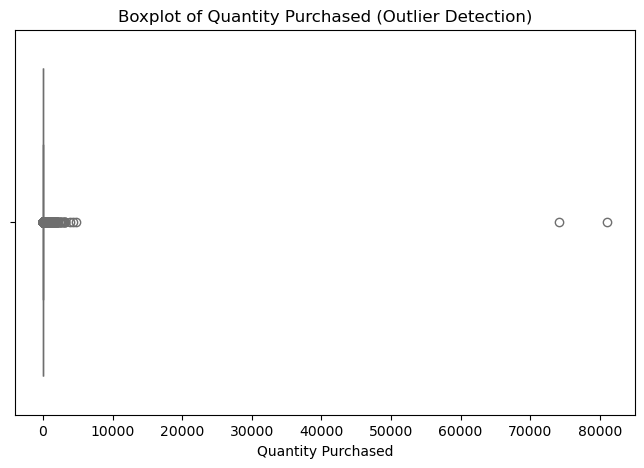

In [376]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_cleaned["Quantity"], color="lightcoral")
plt.xlabel("Quantity Purchased")
plt.title("Boxplot of Quantity Purchased (Outlier Detection)")
plt.show()

In [378]:
# Calculate IQR
Q1 = df_cleaned[["Quantity"]].quantile(0.25)
print(f"Q1:{Q1}")
Q3 = df_cleaned[["Quantity"]].quantile(0.75)
print(f"Q3:{Q3}")
IQR = Q3 - Q1
print(f"IQR:{IQR}")

lower_bound = Q1 - (1.5 * IQR) 
upper_bound = Q3 + (1.5 * IQR) 

print(f"lower_bound: {lower_bound}")
print(f"upper_bound: {upper_bound}")

# Define outliers (1.5*IQR rule)
outliers_top = ((df_cleaned[["Quantity"]] > (upper_bound)))

print(outliers_top.sum())

Q1:Quantity    1.0
Name: 0.25, dtype: float64
Q3:Quantity    10.0
Name: 0.75, dtype: float64
IQR:Quantity    9.0
dtype: float64
lower_bound: Quantity   -12.5
dtype: float64
upper_bound: Quantity    23.5
dtype: float64
Quantity    56363
dtype: int64


In [380]:
upper_bound_value = upper_bound.iloc[0]  # Extract scalar value
df_cleaned = df_cleaned[df_cleaned["Quantity"] < int(upper_bound_value)]

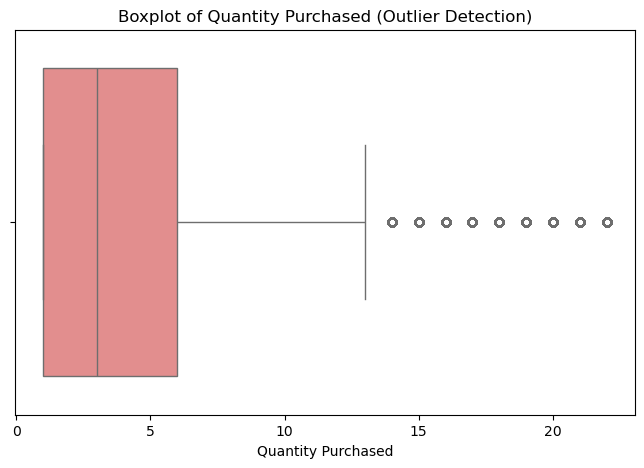

In [382]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_cleaned["Quantity"], color="lightcoral")
plt.xlabel("Quantity Purchased")
plt.title("Boxplot of Quantity Purchased (Outlier Detection)")
plt.show()

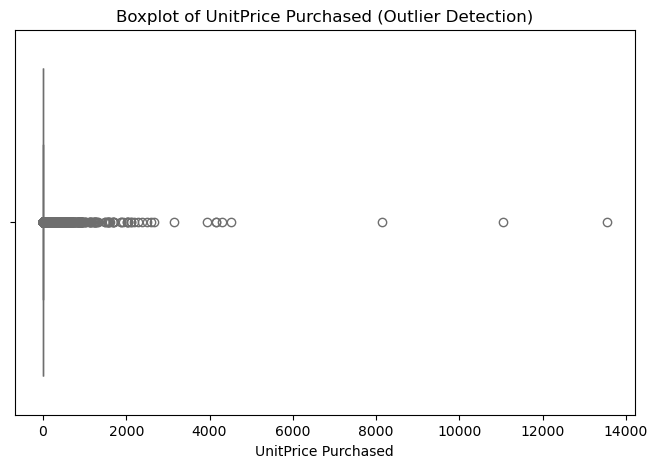

In [384]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_cleaned["UnitPrice"], color="lightcoral")
plt.xlabel("UnitPrice Purchased")
plt.title("Boxplot of UnitPrice Purchased (Outlier Detection)")
plt.show()

In [386]:
temp = df_cleaned[df_cleaned["UnitPrice"] > 6000]
print(temp.shape)

(3, 10)


In [388]:
temp = df_cleaned[df_cleaned["UnitPrice"] > 6000]
temp.head(10)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
15017,15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,0,United Kingdom,13541.33
173382,173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom,8142.75
299982,299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,0,United Kingdom,11062.06


In [390]:
df_cleaned = df_cleaned[df_cleaned["UnitPrice"] < 6000]

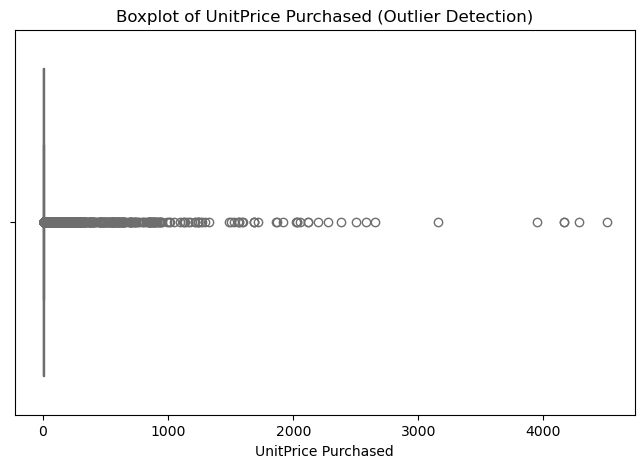

In [392]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_cleaned["UnitPrice"], color="lightcoral")
plt.xlabel("UnitPrice Purchased")
plt.title("Boxplot of UnitPrice Purchased (Outlier Detection)")
plt.show()

In [394]:
#df_cleaned = df_cleaned[df_cleaned["UnitPrice"] < 2500]

In [396]:
#temp = df_cleaned[df_cleaned["Quantity"] > 2500]
#print(temp.shape)

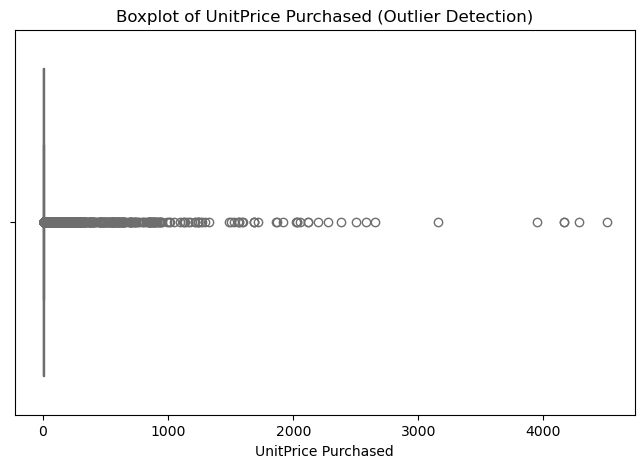

In [398]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_cleaned["UnitPrice"], color="lightcoral")
plt.xlabel("UnitPrice Purchased")
plt.title("Boxplot of UnitPrice Purchased (Outlier Detection)")
plt.show()

In [400]:
#df_cleaned = df_cleaned[df_cleaned["Quantity"] < 2500]

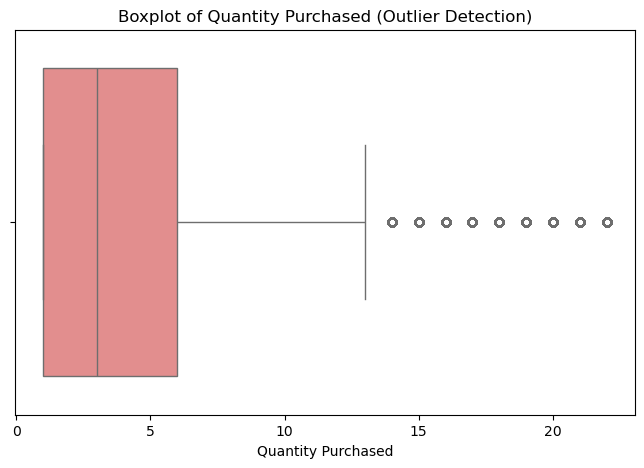

In [402]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_cleaned["Quantity"], color="lightcoral")
plt.xlabel("Quantity Purchased")
plt.title("Boxplot of Quantity Purchased (Outlier Detection)")
plt.show()

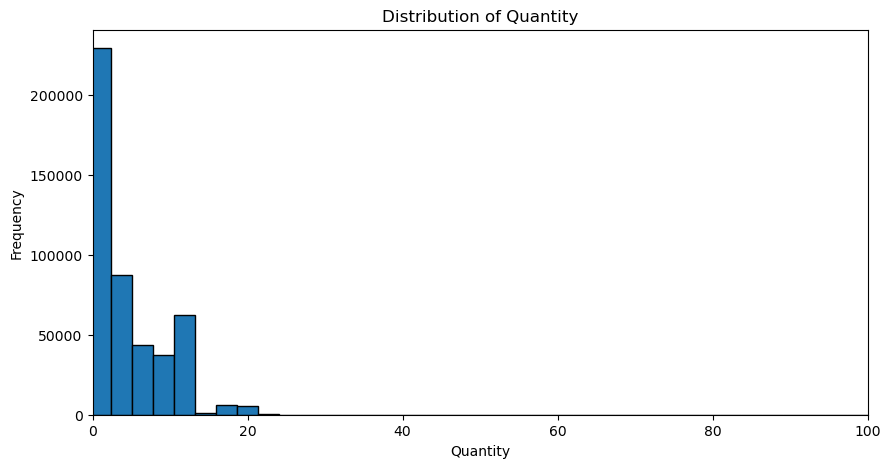

In [404]:
# Visualize distributions of numerical features using histograms
bin_edges = np.linspace(-60, 100, 60)

# Plot histogram for 'quantity'
plt.figure(figsize=(10, 5))
plt.hist(df_cleaned['Quantity'], bins=bin_edges, edgecolor='black')
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.xlim(0,100)
plt.show()


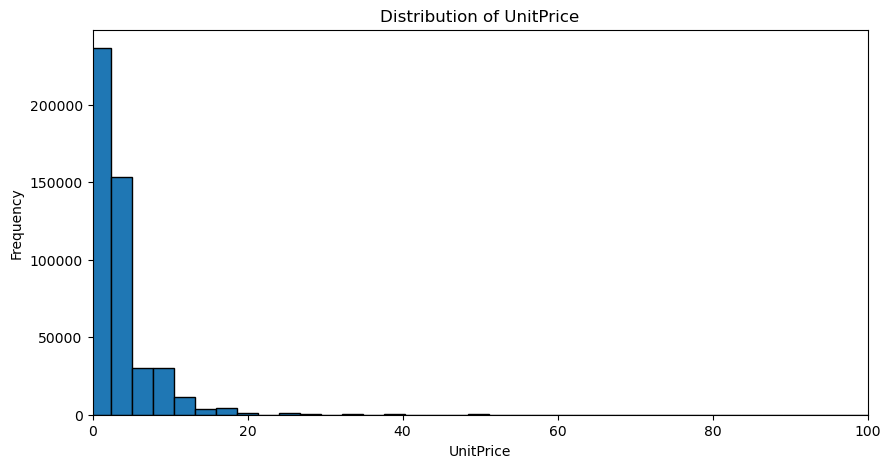

In [406]:
# Visualize distributions of numerical features using histograms
bin_edges = np.linspace(-60, 100, 60)

# Plot histogram for 'quantity'
plt.figure(figsize=(10, 5))
plt.hist(df_cleaned['UnitPrice'], bins=bin_edges, edgecolor='black')
plt.title('Distribution of UnitPrice')
plt.xlabel('UnitPrice')
plt.ylabel('Frequency')
plt.xlim(0,100)
plt.show()


#### Visualizing Correlation Between Numerical Features

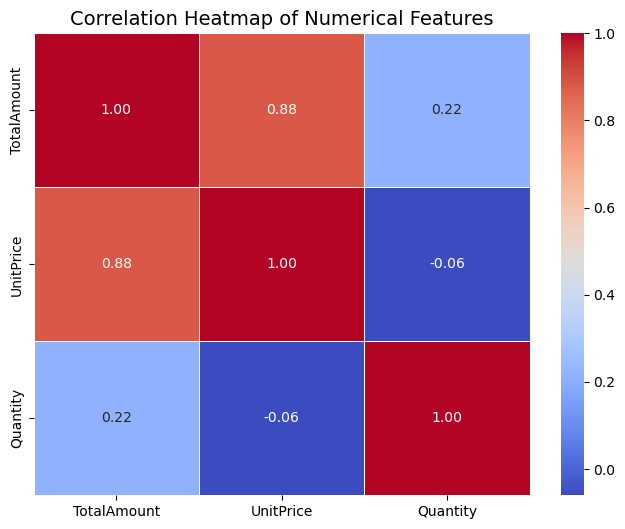

In [408]:
# Compute correlation matrix
correlation_matrix = df_cleaned[["TotalAmount", "UnitPrice", "Quantity"]].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")

# Set title
plt.title("Correlation Heatmap of Numerical Features", fontsize=14)

# Show plot
plt.show()

In [410]:
temp = df_cleaned[(df_cleaned['CustomerID'] > 0)]

In [412]:

# Aggregate total quantity purchased by each CustomerID
customer_orders = temp.groupby("CustomerID")["Quantity"].sum().reset_index()

# Rename columns for clarity
customer_orders.columns = ["CustomerID", "TotalQuantity"]

# Display top 10 customers with the highest total orders
print(customer_orders.sort_values(by="TotalQuantity", ascending=False).head(10))


      CustomerID  TotalQuantity
1833       14911          35738
3904       17841          17674
1259       14096          14391
547        13089          12612
324        12748          12289
1400       14298           7077
543        13081           6945
1916       15039           6853
1300       14156           6559
2120       15311           6364


In [414]:
# Compute IQR
Q1 = customer_orders["TotalQuantity"].quantile(0.25)
Q3 = customer_orders["TotalQuantity"].quantile(0.75)
IQR = Q3 - Q1

# Define threshold for anomalies
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"lower_bound of total quantity:{lower_bound}")
print(f"upper_bound of total quantity:{upper_bound}")

# Identify customers with unusually high order quantities
anomalous_customers = customer_orders[customer_orders["TotalQuantity"] > upper_bound]

# Display anomalous customers
print(f"Total Anomalous Customers: {len(anomalous_customers)}")
print(anomalous_customers)

lower_bound of total quantity:-546.5
upper_bound of total quantity:1145.5
Total Anomalous Customers: 373
      CustomerID  TotalQuantity
0          12347           1300
11         12359           1476
14         12362           1877
26         12378           1566
65         12428           2019
...          ...            ...
4173       18226           2202
4176       18229           1352
4188       18245           1306
4205       18272           1282
4214       18283           1397

[373 rows x 2 columns]


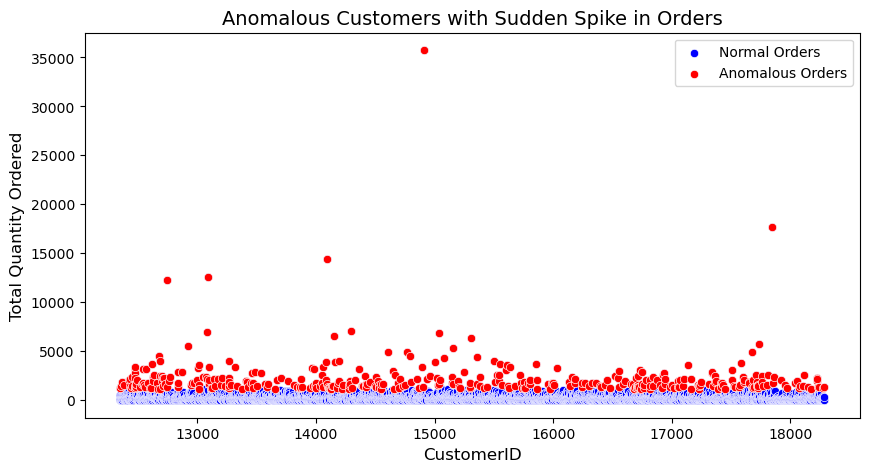

In [416]:
# Plot all customers
plt.figure(figsize=(10, 5))
sns.scatterplot(x=customer_orders["CustomerID"], y=customer_orders["TotalQuantity"], color="blue", label="Normal Orders")

# Highlight anomalies
sns.scatterplot(x=anomalous_customers["CustomerID"], y=anomalous_customers["TotalQuantity"], color="red", label="Anomalous Orders")

# Set labels
plt.xlabel("CustomerID", fontsize=12)
plt.ylabel("Total Quantity Ordered", fontsize=12)
plt.title("Anomalous Customers with Sudden Spike in Orders", fontsize=14)
plt.legend()

# Show plot
plt.show()


In [418]:
temp_customers = customer_orders[customer_orders["TotalQuantity"] > 6000]
temp_customers.head(20)

,CustomerID,TotalQuantity
324,12748,12289
543,13081,6945
547,13089,12612
1259,14096,14391
1300,14156,6559
1400,14298,7077
1833,14911,35738
1916,15039,6853
2120,15311,6364
3904,17841,17674


Removed 10 customers from the dataset.
lower_bound of total quantity:-539.0
upper_bound of total quantity:1133.0
Total Anomalous Customers: 371
      CustomerID  TotalQuantity
0          12347           1300
11         12359           1476
14         12362           1877
26         12378           1566
65         12428           2019
...          ...            ...
4163       18226           2202
4166       18229           1352
4178       18245           1306
4195       18272           1282
4204       18283           1397

[371 rows x 2 columns]


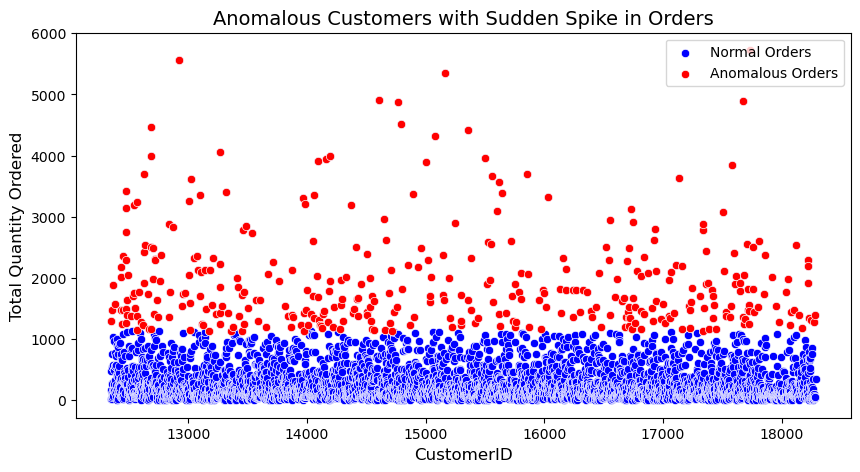

In [420]:
# Filter customers who ordered more than 5000 units
customers_to_remove = customer_orders[customer_orders["TotalQuantity"] > 6000]["CustomerID"]

# Remove those customers from the original dataset
df_temp = temp[~temp["CustomerID"].isin(customers_to_remove)]

# Print confirmation message
print(f"Removed {len(customers_to_remove)} customers from the dataset.")

# 🔄 **Recalculate `customer_orders` after removal**
customer_orders_updated = df_temp.groupby("CustomerID")["Quantity"].sum().reset_index()
customer_orders_updated.columns = ["CustomerID", "TotalQuantity"]

# Compute IQR
Q1 = customer_orders_updated["TotalQuantity"].quantile(0.25)
Q3 = customer_orders_updated["TotalQuantity"].quantile(0.75)
IQR = Q3 - Q1

# Define threshold for anomalies
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"lower_bound of total quantity:{lower_bound}")
print(f"upper_bound of total quantity:{upper_bound}")

# Identify customers with unusually high order quantities
anomalous_customers = customer_orders_updated[customer_orders_updated["TotalQuantity"] > upper_bound]

# Display anomalous customers
print(f"Total Anomalous Customers: {len(anomalous_customers)}")
print(anomalous_customers)

plt.figure(figsize=(10, 5))
sns.scatterplot(x=customer_orders_updated["CustomerID"], y=customer_orders_updated["TotalQuantity"], color="blue", label="Normal Orders")

# Highlight anomalies
sns.scatterplot(x=anomalous_customers["CustomerID"], y=anomalous_customers["TotalQuantity"], color="red", label="Anomalous Orders")

# Set labels
plt.xlabel("CustomerID", fontsize=12)
plt.ylabel("Total Quantity Ordered", fontsize=12)
plt.title("Anomalous Customers with Sudden Spike in Orders", fontsize=14)
plt.legend()

# Show plot
plt.show()


In [422]:
# Compute Z-scores for Quantity
df["z_score"] = stats.zscore(df["Quantity"])

# Find outliers (Threshold: |Z-score| > 3)
outliers = df[df["z_score"].abs() > 3]
print(f"Total Outliers: {len(outliers)}")
print(outliers.head(10))


Total Outliers: 346
       index InvoiceNo StockCode                          Description  \
4287    4287   C536757     84347  ROTATING SILVER ANGELS T-LIGHT HLDR   
4850    4850    536809     84950       ASSORTED COLOUR T-LIGHT HOLDER   
4945    4945    536830     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS   
4946    4946    536830     21915               RED  HARMONICA IN BOX    
6365    6365    536890    17084R                ASSORTED INCENSE PACK   
9745    9745    537214     17003                  BROCADE RING PURSE    
16427  16427    537657     22189              CREAM HEART CARD HOLDER   
16428  16428    537657     22188              BLACK HEART CARD HOLDER   
16435  16435    537659     22189              CREAM HEART CARD HOLDER   
16436  16436    537659     22188              BLACK HEART CARD HOLDER   

       Quantity         InvoiceDate  UnitPrice  CustomerID         Country  \
4287      -9360 2010-12-02 14:23:00       0.03       15838  United Kingdom   
4850       1824 2010

/var/folders/0p/29y5gpjs09jd6rt_9jltqj7w0000gn/T/ipykernel_68648/3709428961.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quantity', y='Description', data=top_10_products, palette='viridis')


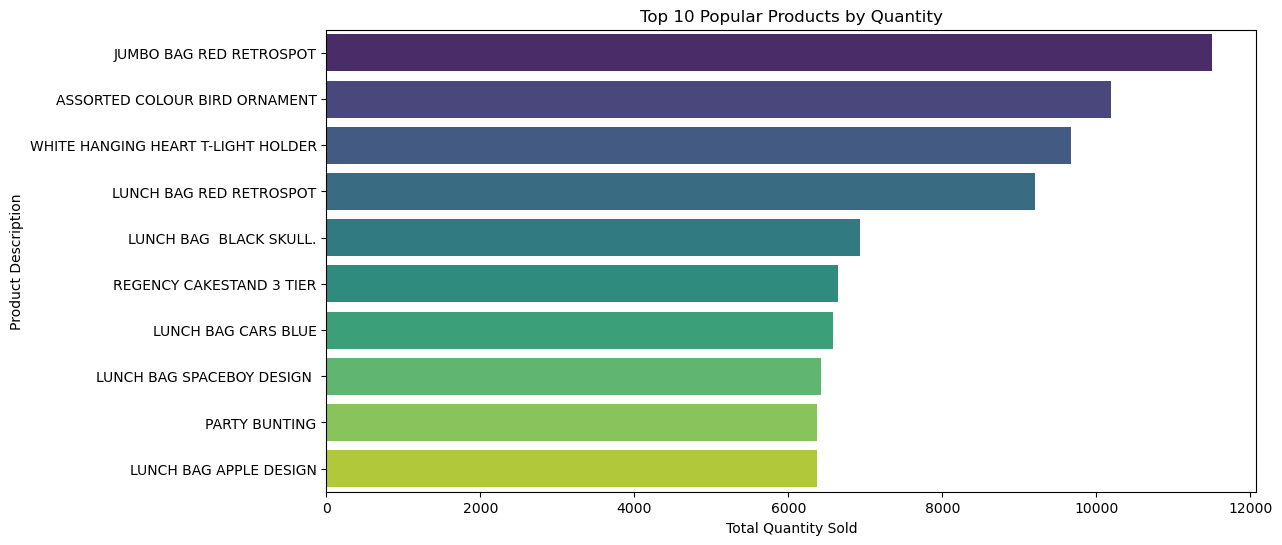

In [424]:
# Aggregate total quantity sold per product
popular_products = df_temp.groupby('Description')['Quantity'].sum().reset_index()

# Sort by highest quantity and take the top 10
top_10_products = popular_products.sort_values(by='Quantity', ascending=False).head(10)

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Quantity', y='Description', data=top_10_products, palette='viridis')

# Add labels and title
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Description')
plt.title('Top 10 Popular Products by Quantity')
plt.show()

### Feature Engineering

In [426]:
df_cleaned.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [428]:
df_cleaned.dtypes

index                   int64
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
TotalAmount           float64
dtype: object

In [278]:
# Transaction features
#df_cleaned['ItemsPerTransaction'] = df_cleaned.groupby('InvoiceNo')['Quantity'].transform('sum')
#df_cleaned['UniqueItemsPerTransaction'] = df_cleaned.groupby('InvoiceNo')['StockCode'].transform('nunique')

In [430]:
# display new features 
#new_features = ['ItemsPerTransaction','UniqueItemsPerTransaction']
#display(df_cleaned[new_features].describe())

In [432]:
# Prepare features for importance analysis
#numeric_features = ['Quantity', 'UnitPrice', 'ItemsPerTransaction', 'UniqueItemsPerTransaction']

#X = df_cleaned[numeric_features]
#y = df_cleaned['TotalAmount']

# Scale the features
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Train a Random Forest model
#rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
#rf_model.fit(X_scaled, y)

# Get feature importance
#feature_importance = pd.DataFrame({
#    'Feature': numeric_features,
#    'Importance': rf_model.feature_importances_
#}).sort_values('Importance', ascending=False)

# Plot feature importance
#plt.figure(figsize=(12, 6))
#sns.barplot(data=feature_importance, x='Feature', y='Importance')
#plt.title('Feature Importance')
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.show()

In [434]:
df_features = df_cleaned[["InvoiceNo", "StockCode", "Quantity","Description"]]
df_features.head()

,InvoiceNo,StockCode,Quantity,Description
0,536365,85123A,6,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,71053,6,WHITE METAL LANTERN
2,536365,84406B,8,CREAM CUPID HEARTS COAT HANGER
3,536365,84029G,6,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,84029E,6,RED WOOLLY HOTTIE WHITE HEART.


In [436]:
list_special_codes = df_features[df_features['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'C2', 'DOT', 'M', 'BANK CHARGES', 'DCGS0076', 'DCGS0003',
       'gift_0001_40', 'DCGS0070', 'm', 'gift_0001_50', 'gift_0001_30',
       'gift_0001_20', 'DCGS0069', 'DCGSSBOY', 'DCGSSGIRL',
       'gift_0001_10', 'AMAZONFEE', 'S', 'PADS', 'DCGS0004'], dtype=object)

In [438]:
# Filter dataset to include only rows with special StockCodes
df_special_codes = df_features[df_features['StockCode'].isin(list_special_codes)]

# Display the filtered data
df_special_codes.head(20)
#df_special_codes.size

,InvoiceNo,StockCode,Quantity,Description
45,536370,POST,3,POSTAGE
386,536403,POST,1,POSTAGE
1123,536527,POST,1,POSTAGE
1423,536540,C2,1,CARRIAGE
1814,536544,DOT,1,DOTCOM POSTAGE
2239,536569,M,1,Manual
2250,536569,M,1,Manual
3041,536592,DOT,1,DOTCOM POSTAGE
4406,536779,BANK CHARGES,1,Bank Charges
5073,536840,POST,1,POSTAGE


In [440]:
# Extract unique StockCode and Description pairs for list_special_codes
unique_stock_descriptions = df_features[df_features['StockCode'].isin(list_special_codes)][['StockCode', 'Description']].drop_duplicates()

# Display the unique StockCode and Description pairs
for index, row in unique_stock_descriptions.iterrows():
    print(f"StockCode: {row['StockCode']} - Description: {row['Description']}")


StockCode: POST - Description: POSTAGE
StockCode: C2 - Description: CARRIAGE
StockCode: DOT - Description: DOTCOM POSTAGE
StockCode: M - Description: Manual
StockCode: BANK CHARGES - Description: Bank Charges
StockCode: DCGS0076 - Description: SUNJAR LED NIGHT NIGHT LIGHT
StockCode: DCGS0003 - Description: BOXED GLASS ASHTRAY
StockCode: gift_0001_40 - Description: Dotcomgiftshop Gift Voucher £40.00
StockCode: DCGS0070 - Description: CAMOUFLAGE DOG COLLAR
StockCode: m - Description: Manual
StockCode: gift_0001_50 - Description: Dotcomgiftshop Gift Voucher £50.00
StockCode: gift_0001_30 - Description: Dotcomgiftshop Gift Voucher £30.00
StockCode: gift_0001_20 - Description: Dotcomgiftshop Gift Voucher £20.00
StockCode: DCGS0069 - Description: OOH LA LA DOGS COLLAR
StockCode: DCGSSBOY - Description: BOYS PARTY BAG
StockCode: DCGSSGIRL - Description: GIRLS PARTY BAG
StockCode: gift_0001_10 - Description: Dotcomgiftshop Gift Voucher £10.00
StockCode: AMAZONFEE - Description: AMAZON FEE
Stoc

In [442]:
list_special_codes_to_removed = ['POST', 'C2', 'DOT', 'M', 'BANK CHARGES', 'm', "AMAZONFEE", "S"]
# Filter dataset to include only rows with special StockCodes
df_special_codes = df_features[df_features['StockCode'].isin(list_special_codes_to_removed)]

# Display the filtered data
df_special_codes.head(30)
#df_special_codes.size

,InvoiceNo,StockCode,Quantity,Description
45,536370,POST,3,POSTAGE
386,536403,POST,1,POSTAGE
1123,536527,POST,1,POSTAGE
1423,536540,C2,1,CARRIAGE
1814,536544,DOT,1,DOTCOM POSTAGE
2239,536569,M,1,Manual
2250,536569,M,1,Manual
3041,536592,DOT,1,DOTCOM POSTAGE
4406,536779,BANK CHARGES,1,Bank Charges
5073,536840,POST,1,POSTAGE


In [444]:
df_features = df_features[~df_features['StockCode'].isin(list_special_codes_to_removed)]

# Display the filtered data
df_features.head(10)

,InvoiceNo,StockCode,Quantity,Description
0,536365,85123A,6,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,71053,6,WHITE METAL LANTERN
2,536365,84406B,8,CREAM CUPID HEARTS COAT HANGER
3,536365,84029G,6,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,84029E,6,RED WOOLLY HOTTIE WHITE HEART.
5,536365,22752,2,SET 7 BABUSHKA NESTING BOXES
6,536365,21730,6,GLASS STAR FROSTED T-LIGHT HOLDER
7,536366,22633,6,HAND WARMER UNION JACK
8,536366,22632,6,HAND WARMER RED POLKA DOT
10,536367,22745,6,POPPY'S PLAYHOUSE BEDROOM


In [446]:
#Ensure no missing values are available in the dataset
print(df_features.isnull().sum())  

InvoiceNo      0
StockCode      0
Quantity       0
Description    0
dtype: int64


In [448]:
# Check for negative values in Quantity
print(df_features[df_features["Quantity"] <= 0].shape[0], "rows with negative Quantity")

0 rows with negative Quantity


In [450]:
# Check for Invalid InvoiceNo
print(df_features[df_features["InvoiceNo"] == 0].shape[0], "rows with negative InvoiceNo")

0 rows with negative InvoiceNo


In [452]:
# Number of Invalid StockCode
invalid_stockcode = (df_features["StockCode"] == 0).sum()

# Print the result
print(f"Number of invalid (zero as value) StockCode: {invalid_stockcode}")

Number of invalid (zero as value) StockCode: 0


#### Data set is now suitable for market basket analysis
##### Attributes under consideration: Quantity, InvoiceNo and StockCode

#### find how many distinct invoices each product

In [456]:
# Count unique invoices per product
product_invoice_counts = df_features.groupby('StockCode')['InvoiceNo'].nunique().reset_index()
# Rename columns for clarity
product_invoice_counts.columns = ['StockCode', 'NumInvoices']

# Merge to include product descriptions
product_invoice_counts = product_invoice_counts.merge(df_features[['StockCode', 'Description']].drop_duplicates(), on='StockCode', how='left')

product_invoice_counts

,StockCode,NumInvoices,Description
0,10002,61,INFLATABLE POLITICAL GLOBE
1,10080,16,GROOVY CACTUS INFLATABLE
2,10120,27,DOGGY RUBBER
3,10123C,3,HEARTS WRAPPING TAPE
4,10124A,5,SPOTS ON RED BOOKCOVER TAPE
...,...,...,...
4080,gift_0001_10,8,Dotcomgiftshop Gift Voucher £10.00
4081,gift_0001_20,9,Dotcomgiftshop Gift Voucher £20.00
4082,gift_0001_30,7,Dotcomgiftshop Gift Voucher £30.00
4083,gift_0001_40,3,Dotcomgiftshop Gift Voucher £40.00


#### find total quantity sold per product

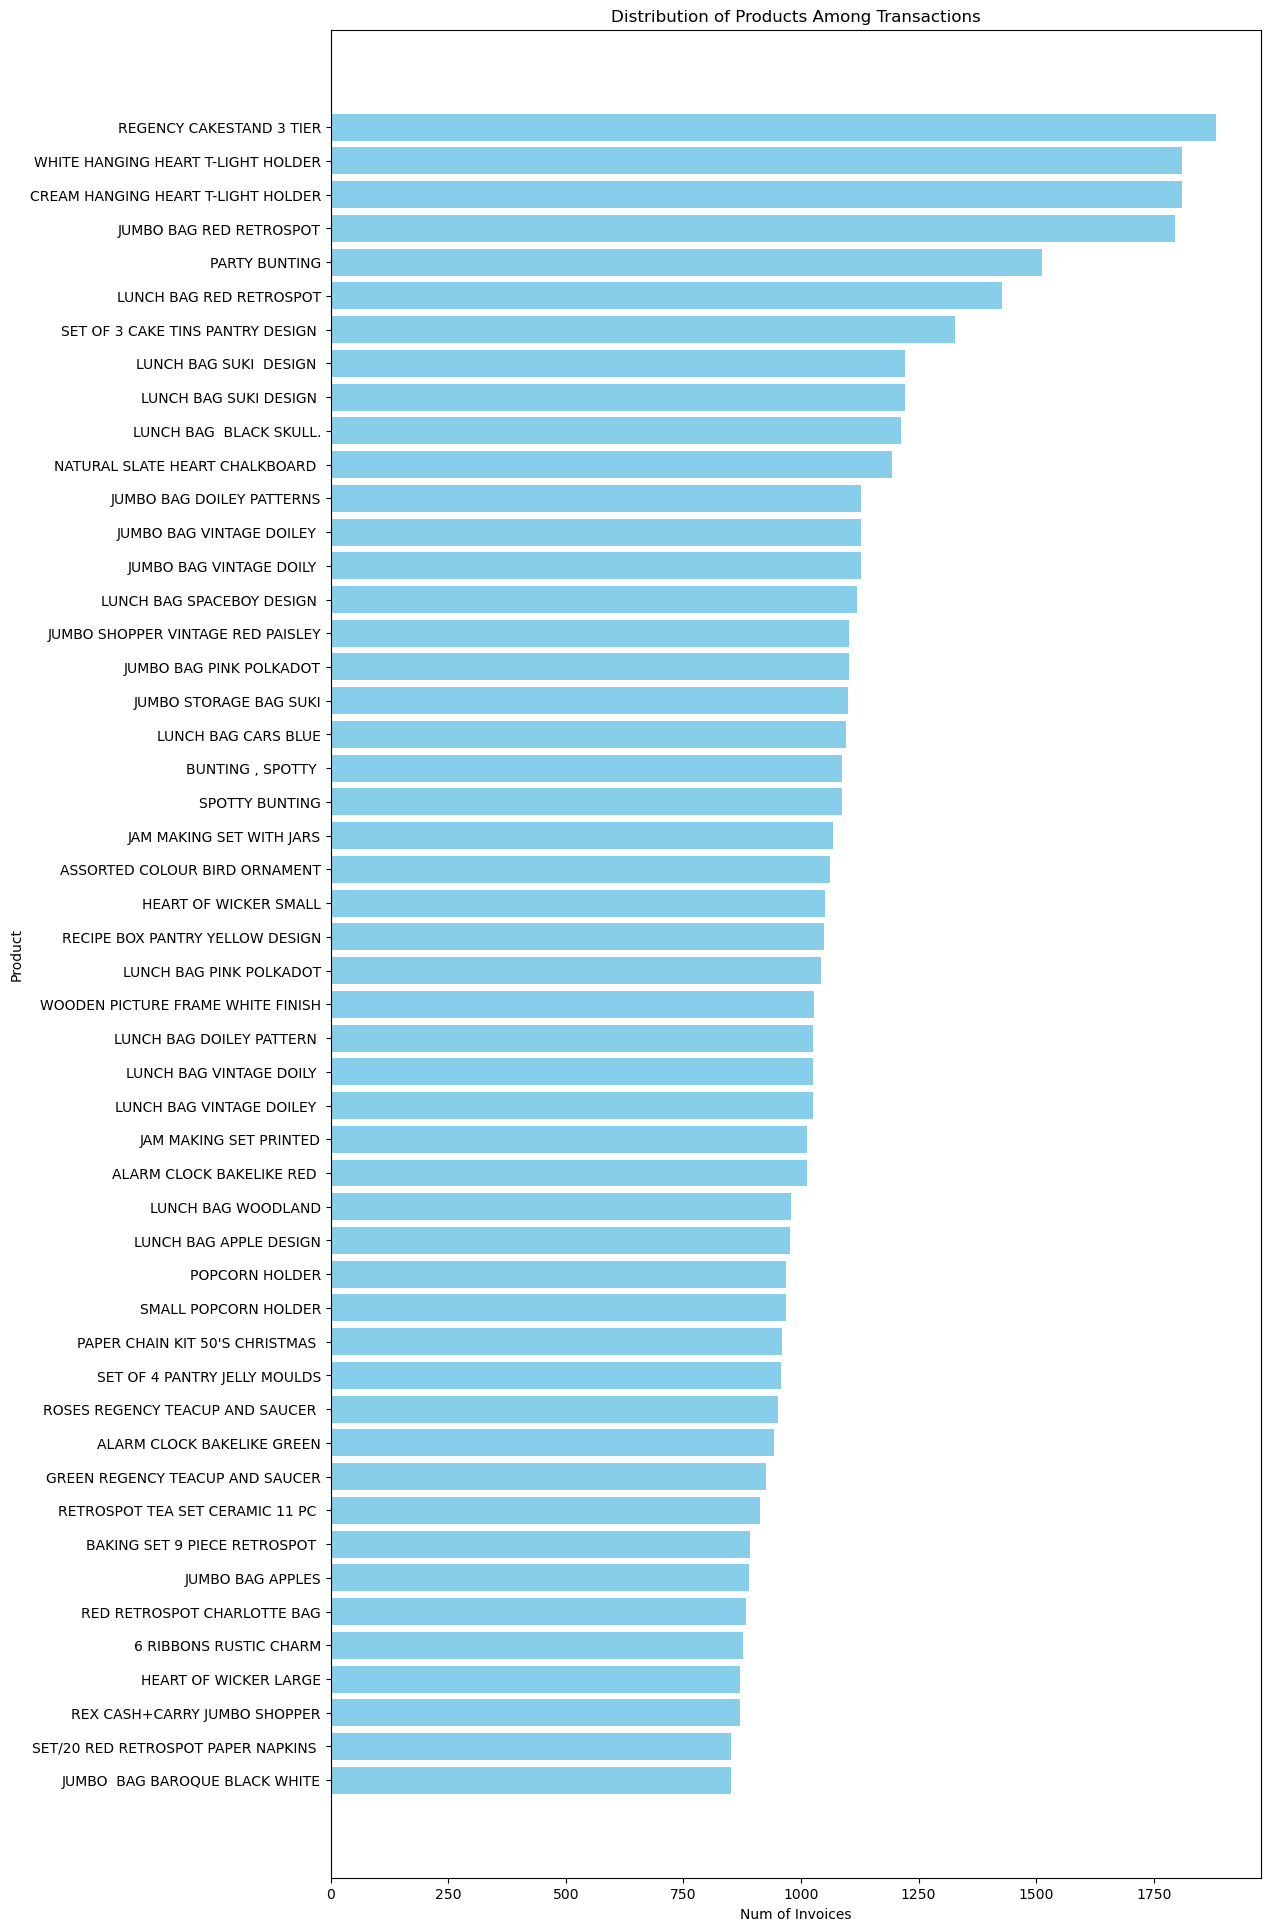

In [459]:
product_invoice_counts = product_invoice_counts.sort_values(by='NumInvoices', ascending=False).head(50)  # Top 100 products

plt.figure(figsize=(12, 24))
plt.barh(product_invoice_counts['Description'], product_invoice_counts['NumInvoices'], color='skyblue')
plt.xlabel("Num of Invoices")
plt.ylabel("Product")
plt.title("Distribution of Products Among Transactions")
plt.gca().invert_yaxis()  # Invert Y-axis for better readability
plt.show()

In [461]:
product_total_quantity = df_features.groupby('StockCode').agg(
    TotalQuantity=('Quantity', 'sum')
).reset_index()

# Merge to include product descriptions
product_total_quantity = product_total_quantity.merge(df_features[['StockCode', 'Description']].drop_duplicates(), on='StockCode', how='left')
product_total_quantity

,StockCode,TotalQuantity,Description
0,10002,318,INFLATABLE POLITICAL GLOBE
1,10080,133,GROOVY CACTUS INFLATABLE
2,10120,133,DOGGY RUBBER
3,10123C,5,HEARTS WRAPPING TAPE
4,10124A,16,SPOTS ON RED BOOKCOVER TAPE
...,...,...,...
4080,gift_0001_10,9,Dotcomgiftshop Gift Voucher £10.00
4081,gift_0001_20,10,Dotcomgiftshop Gift Voucher £20.00
4082,gift_0001_30,7,Dotcomgiftshop Gift Voucher £30.00
4083,gift_0001_40,3,Dotcomgiftshop Gift Voucher £40.00


#### Visualize the distribution of products among transactions (invoices)

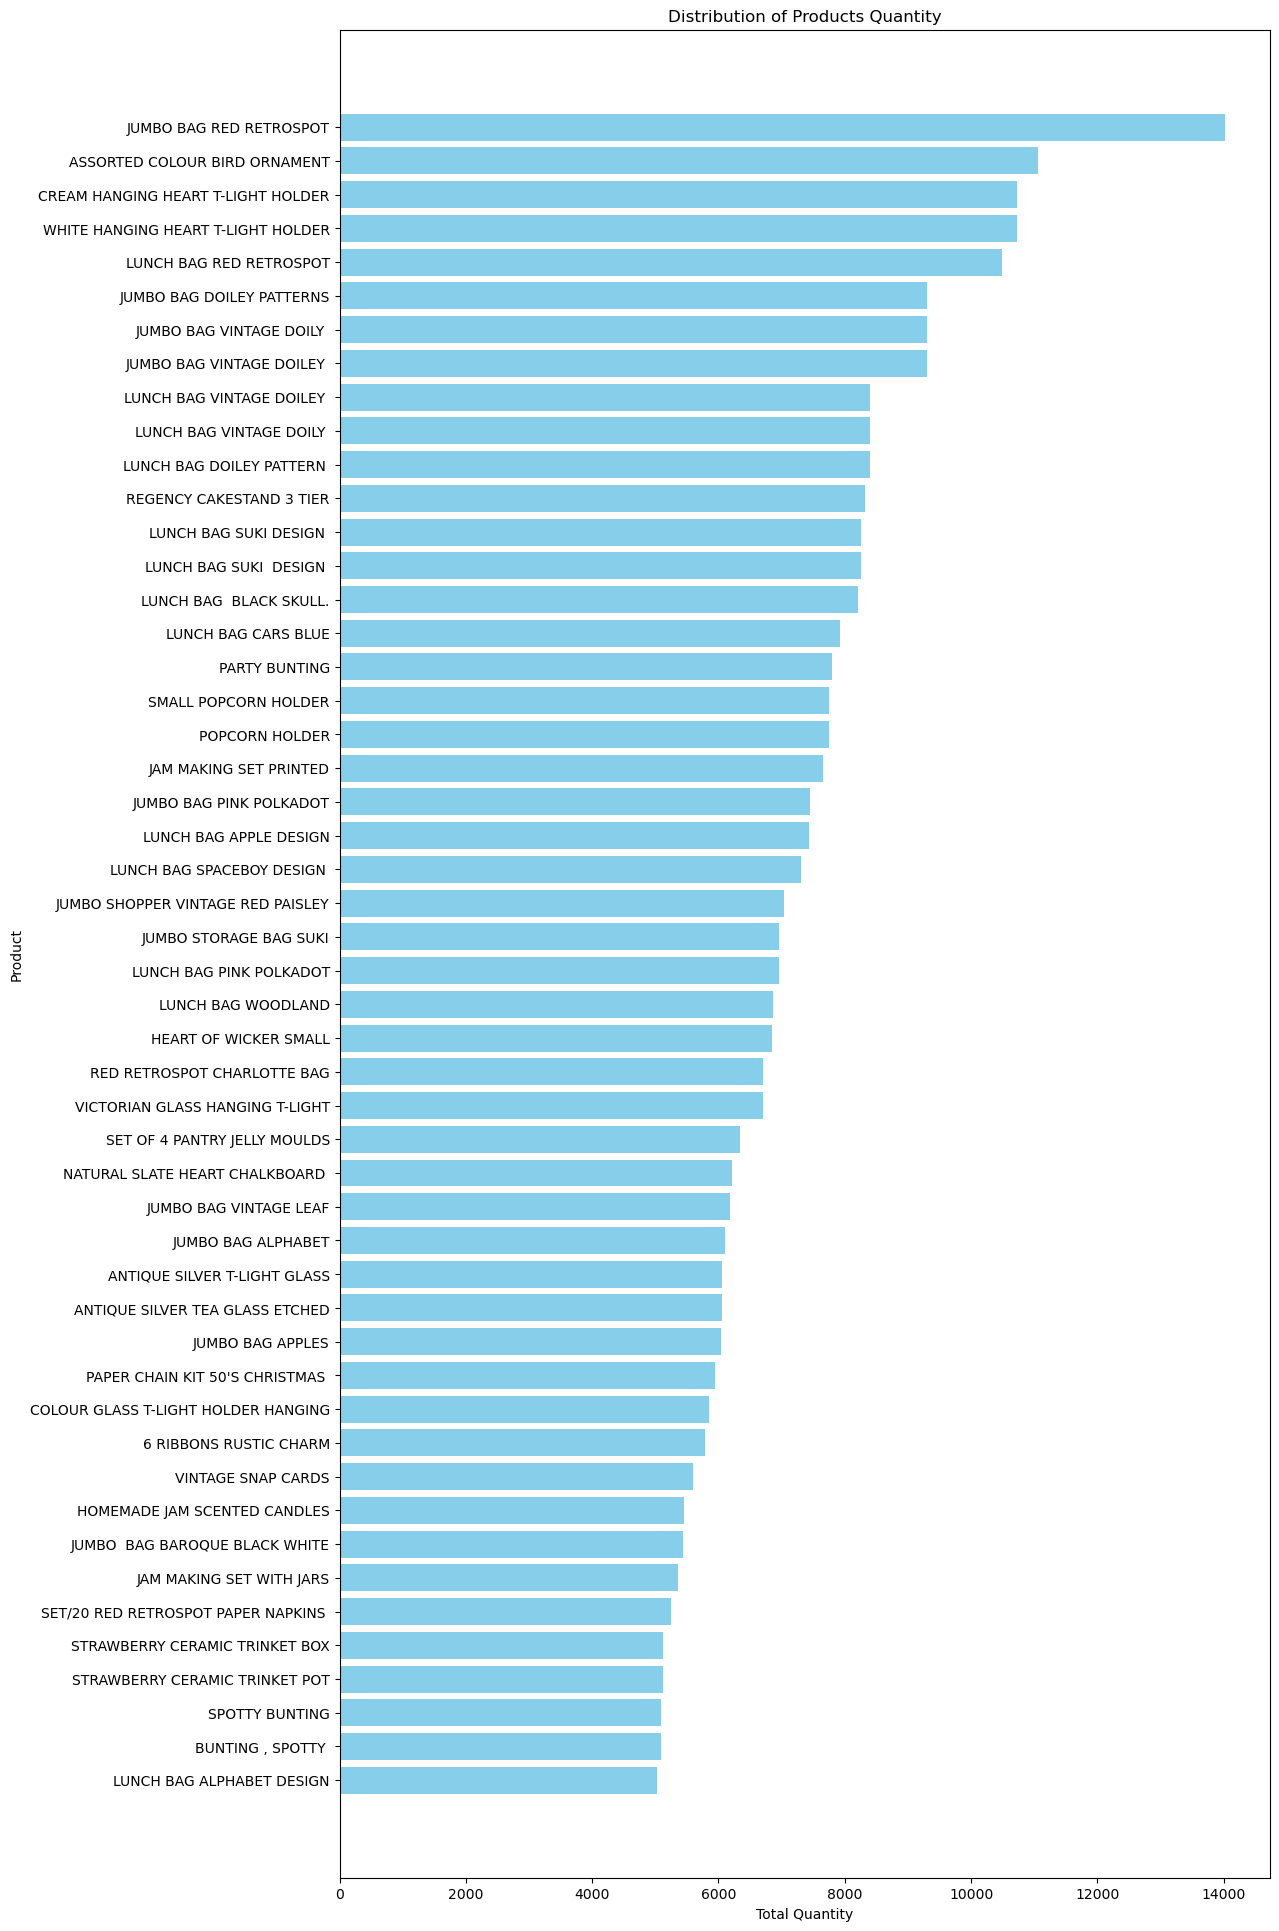

In [464]:
product_total_quantity = product_total_quantity.sort_values(by='TotalQuantity', ascending=False).head(50)  # Top 100 products

plt.figure(figsize=(12, 24))
plt.barh(product_total_quantity['Description'], product_total_quantity['TotalQuantity'], color='skyblue')
plt.xlabel("Total Quantity")
plt.ylabel("Product")
plt.title("Distribution of Products Quantity")
plt.gca().invert_yaxis()  # Invert Y-axis for better readability
plt.show()


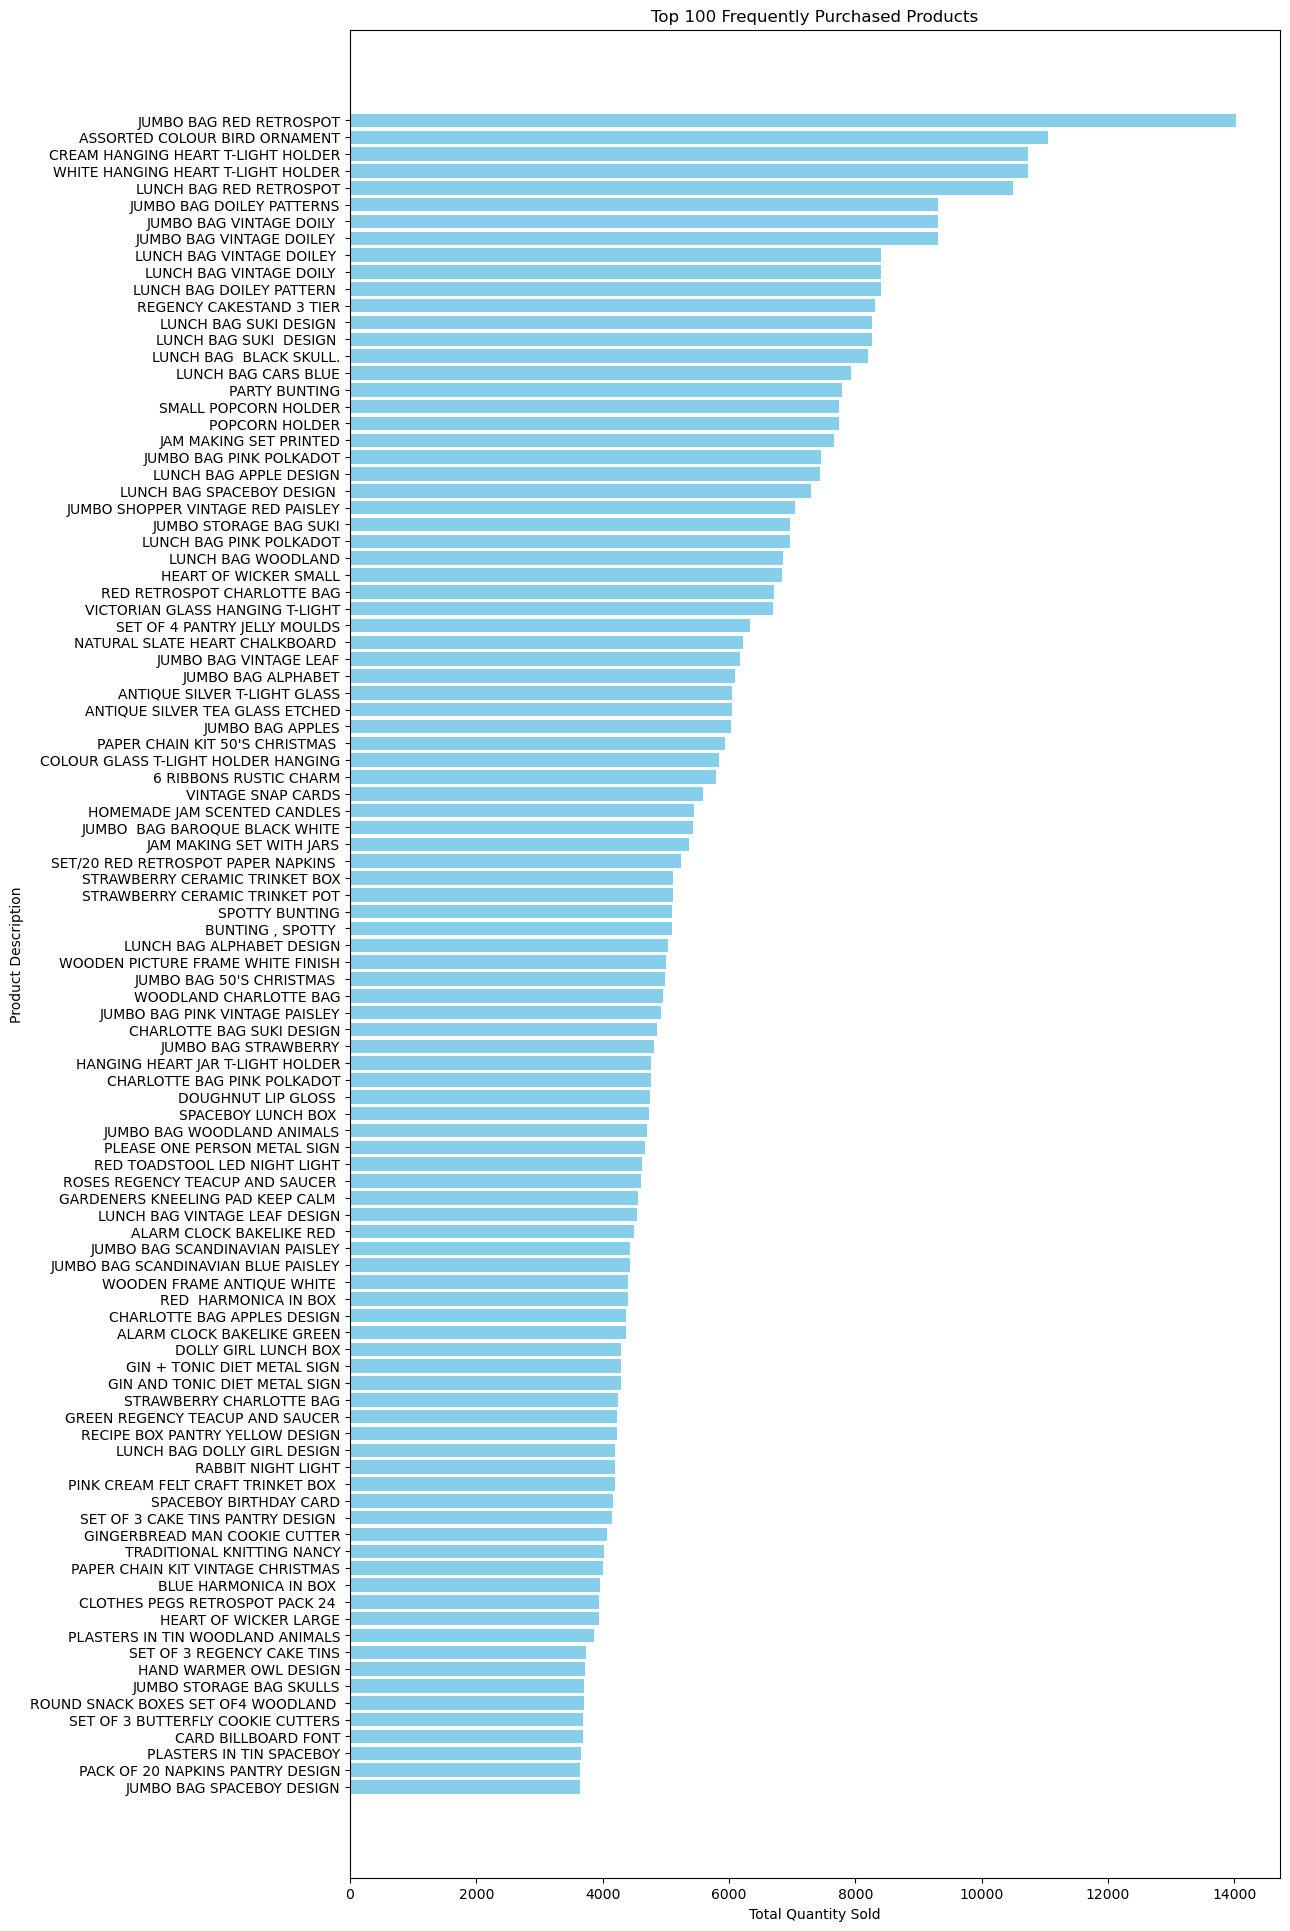

In [466]:
# Aggregate total quantity sold per product
product_sales = df_features.groupby('StockCode').agg(TotalQuantity=('Quantity', 'sum')).reset_index()

# Merge with product descriptions
product_sales = product_sales.merge(df_features[['StockCode', 'Description']].drop_duplicates(), on='StockCode', how='left')

# Sort by most frequently purchased products
top_products = product_sales.sort_values(by='TotalQuantity', ascending=False).head(100)  # Top 100 products

# Plot the top products
plt.figure(figsize=(12, 24))
plt.barh(top_products['Description'], top_products['TotalQuantity'], color='skyblue')
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")
plt.title("Top 100 Frequently Purchased Products")
plt.gca().invert_yaxis()  # Invert Y-axis for better readability
plt.show()


#### Market Basket Analysis

In [477]:
df_features.head()

,InvoiceNo,StockCode,Quantity,Description
0,536365,85123A,6,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,71053,6,WHITE METAL LANTERN
2,536365,84406B,8,CREAM CUPID HEARTS COAT HANGER
3,536365,84029G,6,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,84029E,6,RED WOOLLY HOTTIE WHITE HEART.


In [483]:
df.dtypes

index                   int64
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
z_score               float64
dtype: object

In [487]:
basket = df_features.groupby(['InvoiceNo'])['StockCode'].apply(lambda x: ' '.join(x)).reset_index()
basket.head()

,InvoiceNo,StockCode
0,536365,85123A 71053 84406B 84029G 84029E 22752 21730
1,536366,22633 22632
2,536367,22745 22748 22749 22310 84969 22623 22622 2175...
3,536368,22960 22913 22912 22914
4,536369,21756


#### Prepare Data for Market Basket Analysis

In [503]:
# Pivot the data to create a basket format (transactions vs. products)
basket = df_features.pivot_table(index="InvoiceNo", columns="StockCode", values="Quantity", aggfunc="sum")

# Convert quantities to binary values (0 or 1)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Display prepared data
print(basket.head())

/var/folders/0p/29y5gpjs09jd6rt_9jltqj7w0000gn/T/ipykernel_68648/2804883673.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


StockCode  10002  10080  10120  10123C  10124A  10124G  10125  10133  10135  \
InvoiceNo                                                                     
536365         0      0      0       0       0       0      0      0      0   
536366         0      0      0       0       0       0      0      0      0   
536367         0      0      0       0       0       0      0      0      0   
536368         0      0      0       0       0       0      0      0      0   
536369         0      0      0       0       0       0      0      0      0   

StockCode  11001  ...  DCGS0070  DCGS0076  DCGSSBOY  DCGSSGIRL  PADS  \
InvoiceNo         ...                                                  
536365         0  ...         0         0         0          0     0   
536366         0  ...         0         0         0          0     0   
536367         0  ...         0         0         0          0     0   
536368         0  ...         0         0         0          0     0   
536369        

#### Apply Apriori Algorithm

In [505]:
from mlxtend.frequent_patterns import apriori

# Apply Apriori algorithm
frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)

# Display frequent itemsets
print(frequent_itemsets.head())


/opt/anaconda3/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


    support  itemsets
0  0.022248  (15056N)
1  0.022248   (20676)
2  0.037282   (20685)
3  0.027645   (20711)
4  0.044441   (20712)


#### Generate Association Rules

In [521]:
from mlxtend.frequent_patterns import association_rules

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display top rules
print(rules[["antecedents", "consequents", "support", "confidence", "lift"]].head(10))

  antecedents consequents   support  confidence       lift
0     (20712)     (21931)  0.023184    0.521685   8.612075
1     (21931)     (20712)  0.023184    0.382727   8.612075
2     (20712)     (22386)  0.021532    0.484511   7.983872
3     (22386)     (20712)  0.021532    0.354809   7.983872
4     (20712)    (85099B)  0.026433    0.594796   6.017210
5    (85099B)     (20712)  0.026433    0.267409   6.017210
6     (20719)     (20724)  0.020816    0.541547  11.124386
7     (20724)     (20719)  0.020816    0.427602  11.124386
8     (20723)     (20724)  0.020761    0.609047  12.510952
9     (20724)     (20723)  0.020761    0.426471  12.510952


#### Visualize the Top Association Rules

/var/folders/0p/29y5gpjs09jd6rt_9jltqj7w0000gn/T/ipykernel_68648/3639896819.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rules["lift"], y=top_rules["antecedents"].astype(str), palette="coolwarm")


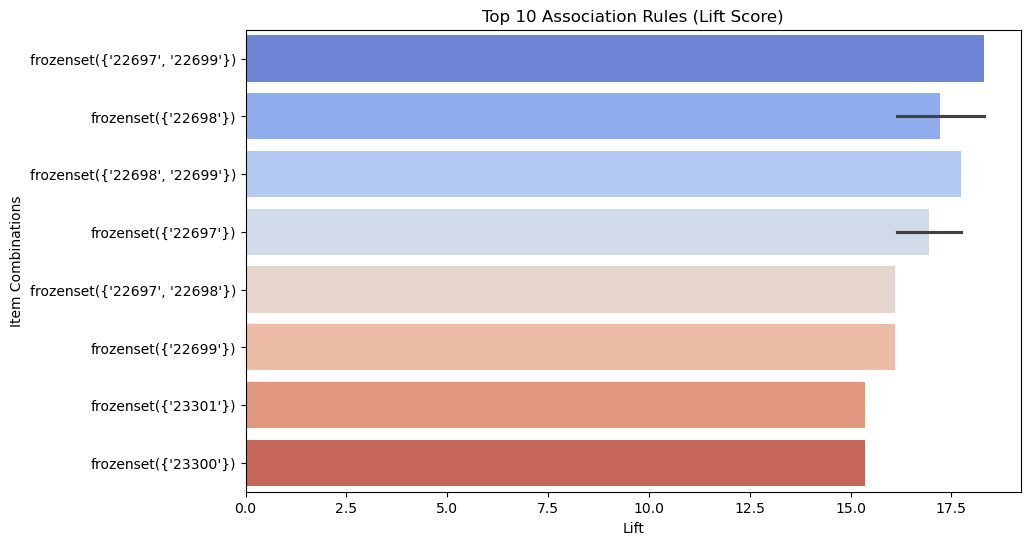

In [524]:
# Select top rules based on lift
top_rules = rules.nlargest(10, "lift")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_rules["lift"], y=top_rules["antecedents"].astype(str), palette="coolwarm")
plt.xlabel("Lift")
plt.ylabel("Item Combinations")
plt.title("Top 10 Association Rules (Lift Score)")
plt.show()

In [540]:
# Define the StockCodes of the items we want to verify
item_1 = "22697"
item_2 = "22699"

# Find invoices that contain item_1
invoices_with_item_1 = df_features[df_features["StockCode"] == item_1]["InvoiceNo"].unique()

# Find invoices that contain item_2
invoices_with_item_2 = df_features[df_features["StockCode"] == item_2]["InvoiceNo"].unique()

# Find invoices that contain both items
common_invoices = set(invoices_with_item_1) & set(invoices_with_item_2)

common_invoices

# Display the common invoices
#print(f"Invoices where both {item_1} and {item_2} were purchased together: {common_invoices}")

# Filter dataset for invoices that contain both items
#df_common_invoices = df_features[df_features["InvoiceNo"].isin(common_invoices)]

# Group by InvoiceNo and aggregate StockCode and Description as lists
#grouped_invoices = df_common_invoices.groupby("InvoiceNo")[["StockCode"]].agg(lambda x: list(x)).reset_index()

#grouped_invoices


{'536544',
 '536592',
 '536627',
 '536856',
 '536865',
 '536876',
 '536946',
 '537042',
 '537179',
 '537237',
 '537240',
 '537313',
 '537378',
 '537385',
 '537396',
 '537434',
 '537435',
 '537638',
 '537642',
 '537643',
 '537666',
 '537823',
 '538071',
 '538148',
 '538153',
 '538177',
 '538370',
 '538566',
 '538660',
 '538851',
 '538880',
 '538951',
 '539217',
 '539434',
 '539437',
 '539442',
 '539451',
 '539593',
 '539609',
 '539708',
 '539736',
 '539738',
 '539739',
 '540372',
 '540418',
 '540464',
 '540499',
 '540539',
 '540662',
 '540777',
 '540907',
 '540915',
 '540992',
 '541008',
 '541129',
 '541133',
 '541280',
 '541421',
 '541497',
 '541584',
 '541592',
 '541783',
 '541811',
 '541866',
 '541999',
 '542087',
 '542102',
 '542255',
 '542543',
 '542583',
 '542590',
 '542600',
 '542622',
 '542647',
 '542664',
 '542717',
 '542719',
 '542729',
 '542862',
 '542881',
 '543022',
 '543036',
 '543097',
 '543106',
 '543107',
 '543116',
 '543246',
 '543251',
 '543277',
 '543370',
 '543451',

In [568]:
# Find invoices that contain item_1
invoices_with_item_1 = df_features[df_features["StockCode"] == "22697"]["InvoiceNo"].unique()

# Find invoices that contain item_2
invoices_with_item_2 = df_features[df_features["StockCode"] == "22699"]["InvoiceNo"].unique()

# Find invoices that contain both items
common_invoices = set(invoices_with_item_1) & set(invoices_with_item_2)

# Filter dataset to show only these invoices
df_verified = df_features[df_features["InvoiceNo"].isin(common_invoices)]

#df_verified

df_single_invoice = df_verified[df_verified["InvoiceNo"] == "536544"]

df_single_invoice.head()

df_single_invoice.to_csv("grouped_invoice_data_536544.csv", index=False)


In [534]:
# Group by InvoiceNo and aggregate StockCode and Description
grouped_invoices = df_features.groupby("InvoiceNo")[["StockCode", "Description"]].agg(lambda x: list(x)).reset_index()

# Display the grouped data
print(grouped_invoices.head(10))  # Show first 10 grouped invoices

# Save the grouped data (Optional)
grouped_invoices.to_csv("grouped_invoice_data.csv", index=False)
print("✅ Grouped invoice data saved as 'grouped_invoice_data.csv'")


  InvoiceNo                                          StockCode  \
0    536365  [85123A, 71053, 84406B, 84029G, 84029E, 22752,...   
1    536366                                     [22633, 22632]   
2    536367  [22745, 22748, 22749, 22310, 84969, 22623, 226...   
3    536368                       [22960, 22913, 22912, 22914]   
4    536369                                            [21756]   
5    536370                [22726, 21724, 21035, 22661, 21913]   
6    536372                                     [22632, 22633]   
7    536373  [85123A, 71053, 84406B, 20679, 37370, 21871, 2...   
8    536375  [85123A, 71053, 84406B, 20679, 37370, 21871, 2...   
9    536377                                     [22632, 22633]   

                                         Description  
0  [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...  
1  [HAND WARMER UNION JACK, HAND WARMER RED POLKA...  
2  [POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...  
3  [JAM MAKING SET WITH JARS, RED COAT RACK PARIS... 